In [1]:
import numpy as np
np.random.seed(123)
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scope import ScopeSolver

import warnings
warnings.filterwarnings('ignore')

DFS-Graph-Trend-Filtering
-------------------------
### Introduction
In this example, we consider further generalizing the 1D piecewise constant trend filtering to the one on a general graph. This generalization from a ordered 1D sequence to a general unordered graph bring challenges for the formal reparametrization strategy. We con not represent the estimator as the sum of successive (higher order) jumps any more since the notion of \"successive\" requires some \"order\" which does not exist on a general graph. To bypass this issue, we consider using the depth first search (DFS) algorithm to transform a general graph to an ordered sequence.

We first introduce the graphical trend filtering. Given a general graph $G=(V, E)$ where $V=\{1, 2, \cdots, n\}$. The observable data is $y\in\mathbb{R}^n$. Graph-Trend-Filtering can be formulated as follows:
\begin{align*}
\hat{\theta} =\underset{\theta \in \mathbb{R}^n}{\operatorname{argmin}} \frac{1}{2}\|y-\theta\|_2^2 \text{ s.t. }\Sigma_{(i, j)\in E}\mathbb{1}_{(\theta_i\neq\theta_j)}\leq k. 
\end{align*}

We can solve the above problem with a two-steps procedure:
* First, we run depth-first-search (DFS) algorithm on $G$ from any startting node $\tau(1)\in V$ to obtain a permutation $\tau$ and a chain (can be viewed as a sorted version of $V$) 
$$\{\tau(1), \tau(2), \cdots, \tau(n)\}.$$

* Then, solving the following saprse optimization with ``scope`` yields the DFS-Graph-Trend-Filtering estimator: 
\begin{align*}
\hat{\theta}_{\mathrm{DFS}} = P^{\top}\left(\underset{\theta \in \mathbb{R}^n}{\operatorname{argmin}} \frac{1}{2}\|P y-\theta\|_2^2 \text{ s.t. }\Sigma_{(i, j)\in E}\mathbb{1}_{(\theta_i\neq\theta_j)}\leq k\right).
\end{align*}
where $P$ is the corresponding permutation matrix of $\tau$.

### Implementation
To illustrate our proposed method. We consider a 2-dimensional grid graph with its nodes taking block-wise constant (see the figure later).

The following class ``Graph`` is initialized as a 2-dimensional grid graph and the implemented method ``dfs`` can transform its unordered nodes into an ordered sequence.

In [2]:
class Graph(object):
    def __init__(self, nrows=2, ncols=2):
        self.nodes = np.arange(nrows * ncols)
        self.graph = {node: [] for node in self.nodes}
        for node, neighbours in self.graph.items():
            up, down, left, right = node - ncols, node + ncols, node - 1, node + 1
            if up >= 0:
                neighbours.append(up)
            if left // ncols == node // ncols:  # in the same row
                neighbours.append(left)
            if (right // ncols == node // ncols) & (right < nrows * ncols):  # in the same row
                neighbours.append(right)
            if (down // ncols <= nrows) & (down < nrows * ncols):
                neighbours.append(down)

    def dfs(self, node): 
        visited, stack = [node], [node]
        while stack:                     
            for v in self.graph[node]:
                if v not in visited:  # if v is not visited, add v to stcak and mark it as visited
                    visited.append(v)                                    
                    stack.append(v)
                    break            
            node = stack[-1]
            if set(self.graph[node]) < set(visited):
                stack.pop()
        self.path = np.array(visited)
        self.p_matrix = np.zeros((len(self.nodes), len(self.nodes)))
        for i, j in zip(self.nodes, self.path):
            self.p_matrix[i, j] = 1
        return self

Then our main function ``denoise`` is implemented in the following. It first transforms the graph into a ordered sequence and then smoothing this sequence using ``trend_filter`` which is especially implemented for 1D sequence.

In [3]:
def trend_filter(y, k):
    y = jnp.array(y)
    p = len(y)

    def custom_objective(params):
        return jnp.sum(jnp.square(y - jnp.cumsum(params)))  # the 
    
    solver = ScopeSolver(p, k)
    params = solver.solve(custom_objective)
    y_pred = jnp.cumsum(params)

    return y_pred

def denoise(data, k):
    nrows, ncols = data.shape
    graph = Graph(nrows=nrows, ncols=ncols)
    graph.dfs(0)
    P = graph.p_matrix  # permutation matrix {1, 2, ..., n} --> {nodes in order visited by DFS}

    y = P @ data.reshape(-1)
    y_hat = P.T @ trend_filter(y, k=k)
    data_hat = y_hat.reshape(nrows, ncols)
    return data_hat

### Synthetic data example
The true signal is construced as follows: we generate a $50\times 50$ matrix and its elements take $3$ distinct values $1, 20, 30$ bolckwisely.

The observed data is then generated by adding noise to the signal.

In [6]:
# signal 
signal = np.zeros((50, 50))
signal[:25, :] = 1
signal[25:, :25] = 10
signal[25:, 25:] = 20

# noisy data
data = signal + np.random.randn(*signal.shape)  # add some noise

# denoised data
data_hat = denoise(data, k=40)

The true signal, noisy data and denoised data estimated by ``denoise`` are plotted respectively in the following figure.

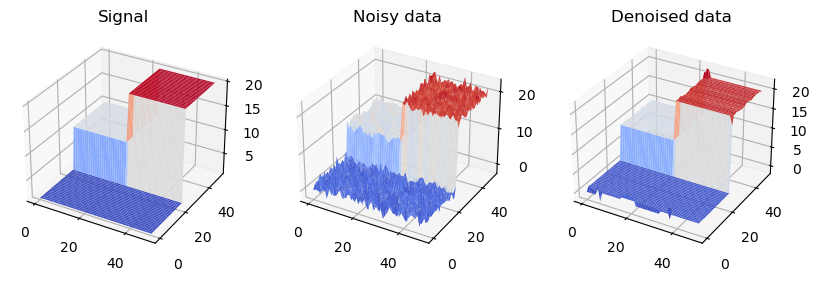

In [5]:
fig = plt.figure(figsize=(10, 5))  

xx = np.arange(data.shape[0])
yy = np.arange(data.shape[1])
X, Y = np.meshgrid(xx, yy)

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, signal, cmap='coolwarm')
ax1.set_title('Signal')


ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, data, cmap='coolwarm')
ax2.set_title('Noisy data')


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, data_hat, cmap='coolwarm')
ax3.set_title('Denoised data')
plt.show()

## Reference

- [1] Depth-first search. https://en.wikipedia.org/wiki/Depth-first_search
- [2] Padilla O H M, Sharpnack J, Scott J G, et al. The DFS Fused Lasso: Linear-Time Denoising over General Graphs[J]. J. Mach. Learn. Res., 2017, 18(1): 6410-6445.